In [1]:
import keras 
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Using TensorFlow backend.


The Reuters dataset contains reviews with the 10,000 most common words.  We have 46 different topics we're trying to classify.  This is a classic **multi-classification** or **multi-label** problem

# Loading the Data

Again, we have to use a little trick to load this data set because of the `allow_pickle` issue

In [3]:
from keras.datasets import reuters

import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

# Encoding

Again, we only have the 10,000 most common words for our input, so we'll use that as our dimension.  However, for the labels, we have 46 topics - this means we need a dimensionality of 46. 

In [5]:
# Define a function to encode/vectorize - one hot encoding. 

def vectorize_sequences(sequences, dimension=10000):
    # Initialize the results equal to a matrix of all zeroes, with the rows being the amount of word_indices provided and the columns being the dimensions, or the samples
    results = np.zeros((len(sequences), dimension))
    # Set the indices which have words at them equal to 1
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

# Use default dimensions for input

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Use 46 for output dimensionality 

y_train = vectorize_sequences(train_labels, 46)
y_test = vectorize_sequences(test_labels, 46)

We can also do this much easier with the built in `to_categorical()` function in the `keras.utils.np_utils` module. 

In [6]:
from keras.utils.np_utils import to_categorical 

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

# Sculpt

We have a **bottleneck** issue here.  In a `Dense` stack, because each layer relies on the output from the previous layer, information can easily be lost.  When we have a lot of dimensions (46), we need more layers.  Rather than using 16 layers/neurons like we did for our binary classification, we'll quadruple that, and use 64.

In [9]:
from tensorflow.keras import models 
from tensorflow.keras import layers 

# Construct our network 

model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Notice that our output layer is a bit different: 
* Our output must be of the same layers as the dimensions of our label vector (46)
* We use `softmax` activation, because we want **probability distributions**

# Compile 

This time, we're gonna use `categorical_crossentropy` as our loss function.  This is because it measures the distance between **two** probability distributions - our probability predictions and the distribution of the labels. 

In [10]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Validation

In [32]:
one_hot_test_labels = vectorize_sequences(test_labels, 46)
one_hot_test_labels.shape

(2246, 46)

In [33]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [34]:
history = model.fit(partial_x_train, partial_y_train, epochs=20,
                    batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 0s 27ms/step - loss: 2.6479 - accuracy: 0.5427 - val_loss: 1.7590 - val_accuracy: 0.6430
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 1.4184 - accuracy: 0.7068 - val_loss: 1.3000 - val_accuracy: 0.7120
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.0514 - accuracy: 0.7774 - val_loss: 1.1527 - val_accuracy: 0.7480
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8301 - accuracy: 0.8230 - val_loss: 1.0477 - val_accuracy: 0.7790
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.6699 - accuracy: 0.8564 - val_loss: 0.9804 - val_accuracy: 0.7910
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.5338 - accuracy: 0.8881 - val_loss: 0.9453 - val_accuracy: 0.7940
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.4338 - accuracy: 0.9112 - val_loss: 0.9084 - val_accuracy: 0.8110
Epoch 8/20
16

Here's a sweet little library I found for plotting loss and accuracy on neural networks.  It's called [plot-keras-history](https://pypi.org/project/plot-keras-history/)

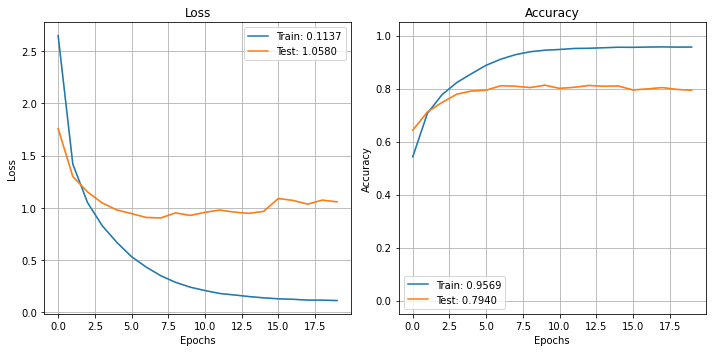

In [41]:
from plot_keras_history import plot_history 
import matplotlib.pyplot as plt 

plot_history(history.history)
plt.show()

We start to overfit after nine epochs.  That's where the loss of our test data increases and our accuracy starts to level out.  Thus, we aren't really gaining anything from that loss. 

In [42]:
history = model.fit(partial_x_train, partial_y_train, epochs=9,
                    batch_size=512, validation_data=(x_val, y_val))

Epoch 1/9
16/16 [==============================] - 0s 18ms/step - loss: 0.1086 - accuracy: 0.9584 - val_loss: 1.0757 - val_accuracy: 0.8060
Epoch 2/9
16/16 [==============================] - 0s 15ms/step - loss: 0.1089 - accuracy: 0.9560 - val_loss: 1.1793 - val_accuracy: 0.7940
Epoch 3/9
16/16 [==============================] - 0s 16ms/step - loss: 0.1030 - accuracy: 0.9579 - val_loss: 1.1961 - val_accuracy: 0.7900
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.1014 - accuracy: 0.9575 - val_loss: 1.1551 - val_accuracy: 0.7970
Epoch 5/9
16/16 [==============================] - 0s 15ms/step - loss: 0.1012 - accuracy: 0.9575 - val_loss: 1.1952 - val_accuracy: 0.7980
Epoch 6/9
16/16 [==============================] - 0s 15ms/step - loss: 0.0972 - accuracy: 0.9605 - val_loss: 1.1685 - val_accuracy: 0.7950
Epoch 7/9
16/16 [==============================] - 0s 15ms/step - loss: 0.1035 - accuracy: 0.9585 - val_loss: 1.2219 - val_accuracy: 0.7890
Epoch 8/9
16/16 [===

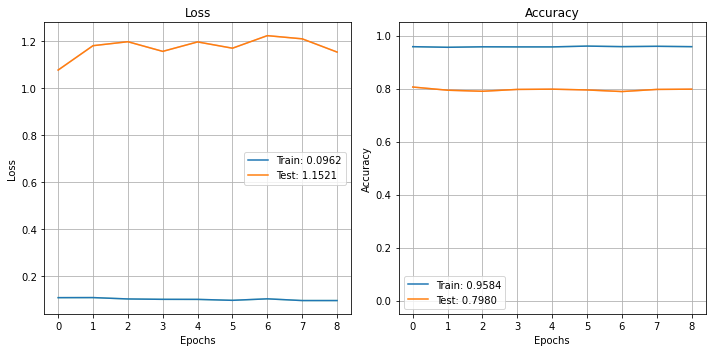

In [43]:
plot_history(history.history)
plt.show()

In [45]:
results = model.evaluate(x_test, one_hot_test_labels)

71/71 [==============================] - 0s 1ms/step - loss: 1.3170 - accuracy: 0.7912


Not bad.  80% accuracy and 1.37 loss. By the way, that 1.37?  That's a scalar, representing the MSE.  

# Hidden units/layers

Let's see what happens when we switch up the number of hidden units or layers we use.  First, let's lower our hidden units. 

Here's the same code with 30 hidden units rather than 64.

Epoch 1/9
16/16 [==============================] - 0s 18ms/step - loss: 3.0416 - accuracy: 0.5089 - val_loss: 2.2926 - val_accuracy: 0.5790
Epoch 2/9
16/16 [==============================] - 0s 11ms/step - loss: 1.9071 - accuracy: 0.6257 - val_loss: 1.6814 - val_accuracy: 0.6290
Epoch 3/9
16/16 [==============================] - 0s 11ms/step - loss: 1.4508 - accuracy: 0.6810 - val_loss: 1.4256 - val_accuracy: 0.6700
Epoch 4/9
16/16 [==============================] - 0s 11ms/step - loss: 1.2043 - accuracy: 0.7295 - val_loss: 1.2934 - val_accuracy: 0.7230
Epoch 5/9
16/16 [==============================] - 0s 12ms/step - loss: 1.0355 - accuracy: 0.7720 - val_loss: 1.1947 - val_accuracy: 0.7500
Epoch 6/9
16/16 [==============================] - 0s 12ms/step - loss: 0.8997 - accuracy: 0.8062 - val_loss: 1.1275 - val_accuracy: 0.7570
Epoch 7/9
16/16 [==============================] - 0s 11ms/step - loss: 0.7858 - accuracy: 0.8329 - val_loss: 1.0849 - val_accuracy: 0.7670
Epoch 8/9
16/16 [===

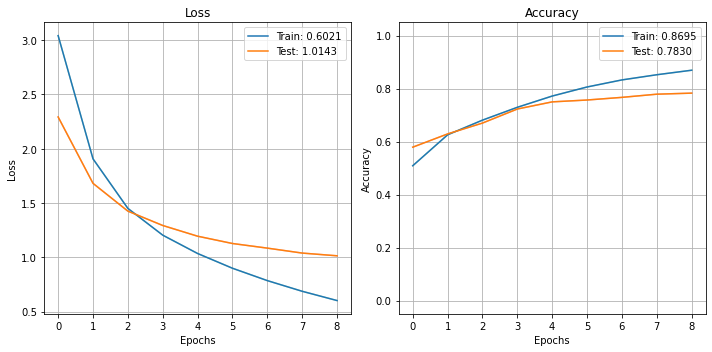

71/71 [==============================] - 0s 988us/step - loss: 1.0767 - accuracy: 0.7591


In [48]:
model = models.Sequential()
model.add(layers.Dense(30, activation = 'relu', input_shape = (10000, )))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=9,
                    batch_size=512, validation_data=(x_val, y_val))
plot_history(history.history)
plt.show()
results = model.evaluate(x_test, one_hot_test_labels)

We lost some accuracy here. What if we increase the hidden units to 80?

Epoch 1/9
16/16 [==============================] - 0s 21ms/step - loss: 2.4226 - accuracy: 0.5319 - val_loss: 1.5985 - val_accuracy: 0.6360
Epoch 2/9
16/16 [==============================] - 0s 16ms/step - loss: 1.3130 - accuracy: 0.7120 - val_loss: 1.2458 - val_accuracy: 0.7260
Epoch 3/9
16/16 [==============================] - 0s 16ms/step - loss: 0.9703 - accuracy: 0.7868 - val_loss: 1.0875 - val_accuracy: 0.7680
Epoch 4/9
16/16 [==============================] - 0s 16ms/step - loss: 0.7340 - accuracy: 0.8418 - val_loss: 1.0200 - val_accuracy: 0.7690
Epoch 5/9
16/16 [==============================] - 0s 17ms/step - loss: 0.5631 - accuracy: 0.8851 - val_loss: 0.9415 - val_accuracy: 0.8030
Epoch 6/9
16/16 [==============================] - 0s 17ms/step - loss: 0.4398 - accuracy: 0.9103 - val_loss: 0.9269 - val_accuracy: 0.7960
Epoch 7/9
16/16 [==============================] - 0s 16ms/step - loss: 0.3431 - accuracy: 0.9288 - val_loss: 0.8921 - val_accuracy: 0.8130
Epoch 8/9
16/16 [===

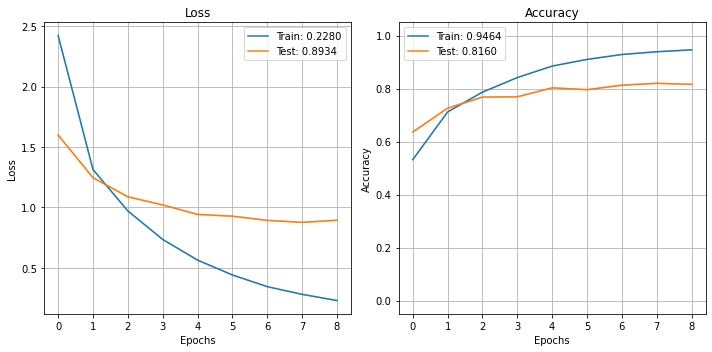

71/71 [==============================] - 0s 1ms/step - loss: 0.9625 - accuracy: 0.7947


In [49]:
model = models.Sequential()
model.add(layers.Dense(80, activation = 'relu', input_shape = (10000, )))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=9,
                    batch_size=512, validation_data=(x_val, y_val))
plot_history(history.history)
plt.show()
results = model.evaluate(x_test, one_hot_test_labels)

Ok, slightly better there.  Loss has improved, and accuracy has.  Now, let's mess with the layers.  Let's add three. 

Epoch 1/9
16/16 [==============================] - 0s 27ms/step - loss: 2.4719 - accuracy: 0.4736 - val_loss: 1.6454 - val_accuracy: 0.6220
Epoch 2/9
16/16 [==============================] - 0s 19ms/step - loss: 1.4428 - accuracy: 0.6718 - val_loss: 1.4425 - val_accuracy: 0.6610
Epoch 3/9
16/16 [==============================] - 0s 18ms/step - loss: 1.1492 - accuracy: 0.7219 - val_loss: 1.2391 - val_accuracy: 0.7170
Epoch 4/9
16/16 [==============================] - 0s 19ms/step - loss: 0.9287 - accuracy: 0.7813 - val_loss: 1.2717 - val_accuracy: 0.7010
Epoch 5/9
16/16 [==============================] - 0s 22ms/step - loss: 0.7639 - accuracy: 0.8157 - val_loss: 1.1008 - val_accuracy: 0.7730
Epoch 6/9
16/16 [==============================] - 0s 20ms/step - loss: 0.6070 - accuracy: 0.8544 - val_loss: 1.1926 - val_accuracy: 0.7580
Epoch 7/9
16/16 [==============================] - 0s 19ms/step - loss: 0.5320 - accuracy: 0.8723 - val_loss: 1.0727 - val_accuracy: 0.7940
Epoch 8/9
16/16 [===

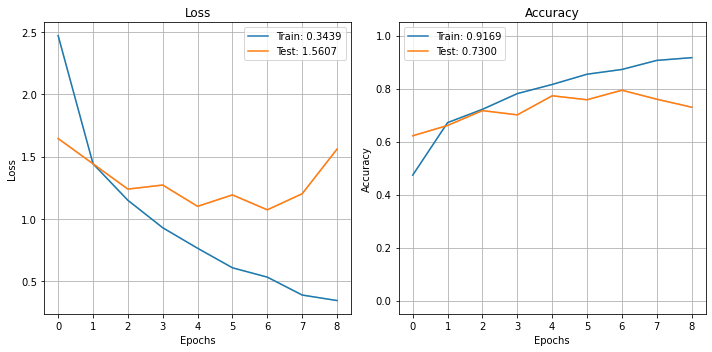

71/71 [==============================] - 0s 1ms/step - loss: 1.6982 - accuracy: 0.6879


In [50]:
model = models.Sequential()
model.add(layers.Dense(80, activation = 'relu', input_shape = (10000, )))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=9,
                    batch_size=512, validation_data=(x_val, y_val))
plot_history(history.history)
plt.show()
results = model.evaluate(x_test, one_hot_test_labels)

Alright, that sucked.  What if we take one away?

Epoch 1/9
16/16 [==============================] - 0s 23ms/step - loss: 2.5162 - accuracy: 0.5779 - val_loss: 1.7278 - val_accuracy: 0.6810
Epoch 2/9
16/16 [==============================] - 0s 17ms/step - loss: 1.3672 - accuracy: 0.7487 - val_loss: 1.2618 - val_accuracy: 0.7460
Epoch 3/9
16/16 [==============================] - 0s 17ms/step - loss: 0.9626 - accuracy: 0.8140 - val_loss: 1.0671 - val_accuracy: 0.7880
Epoch 4/9
16/16 [==============================] - 0s 17ms/step - loss: 0.7324 - accuracy: 0.8578 - val_loss: 0.9517 - val_accuracy: 0.8100
Epoch 5/9
16/16 [==============================] - 0s 17ms/step - loss: 0.5755 - accuracy: 0.8899 - val_loss: 0.8867 - val_accuracy: 0.8180
Epoch 6/9
16/16 [==============================] - 0s 15ms/step - loss: 0.4616 - accuracy: 0.9092 - val_loss: 0.8495 - val_accuracy: 0.8190
Epoch 7/9
16/16 [==============================] - 0s 16ms/step - loss: 0.3772 - accuracy: 0.9255 - val_loss: 0.8267 - val_accuracy: 0.8210
Epoch 8/9
16/16 [===

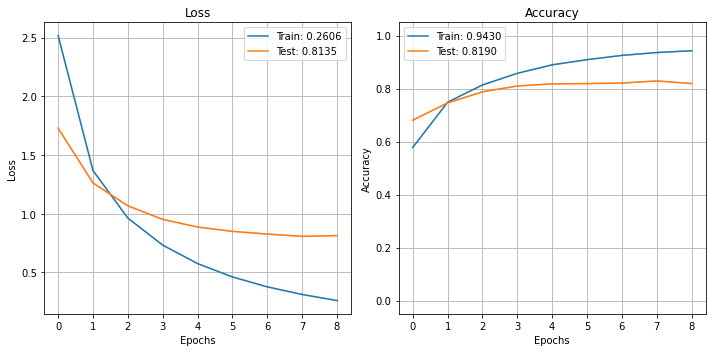

71/71 [==============================] - 0s 1ms/step - loss: 0.8949 - accuracy: 0.8019


In [51]:
model = models.Sequential()
model.add(layers.Dense(80, activation = 'relu', input_shape = (10000, )))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=9,
                    batch_size=512, validation_data=(x_val, y_val))
plot_history(history.history)
plt.show()
results = model.evaluate(x_test, one_hot_test_labels)

That's our best of all!  One hidden layer, 80 hidden units.  Intriguing.  